# Akcje - użycie AutoGluon

### Importy

In [10]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import matplotlib.pyplot as plt
from autogluon.timeseries.splitter import MultiWindowSplitter
import yfinance as yf
import pandas as pd
import datetime
import numpy as np

### Utworzenie danych dla Boeing

In [166]:
stock_symbol = "BA"  
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=365 * 4)  

df = yf.download(stock_symbol, start=start_date, end=end_date)

df.head()

df_snp = yf.download('^GSPC', start=start_date, end=end_date)
df_usd = yf.download('EURUSD=X', start=start_date, end=end_date)
df_snp_shift = df_snp.reset_index()
df_usd_shift = df_usd.reset_index()
df = df.reset_index()
df_full = pd.merge(df, df_snp_shift, on='Date', how='left', suffixes=('', '_snp'))
df_full = pd.merge(df_full, df_usd_shift, on='Date', how='left', suffixes=('', '_usd'))

num_rows = len(df_full)

start_date = '01-01-2019'
date_range = pd.date_range(start=start_date, periods=num_rows)

df_full['Date'] = date_range

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [171]:
df_full.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Open_snp,High_snp,Low_snp,Close_snp,Adj Close_snp,Volume_snp,Open_usd,High_usd,Low_usd,Close_usd,Adj Close_usd,Volume_usd,id
0,2019-01-01,341.500000,344.980011,339.489990,340.880005,336.897766,3234500,3032.120117,3044.080078,3032.120117,3039.419922,3039.419922,3524970000,1.108475,1.110667,1.107714,1.108426,1.108426,0,0
1,2019-01-02,340.190002,349.720001,339.220001,348.929993,344.853729,6113600,3035.389893,3047.870117,3034.810059,3036.889893,3036.889893,3594430000,1.110248,1.111877,1.107506,1.109915,1.109915,0,0
2,2019-01-03,346.630005,350.000000,343.269989,346.059998,342.017273,3997600,3039.739990,3050.100098,3025.959961,3046.770020,3046.770020,3779660000,1.111222,1.112595,1.110334,1.111482,1.111482,0,0
3,2019-01-04,344.700012,346.059998,339.450012,339.910004,335.939117,3868400,3046.899902,3046.899902,3023.189941,3037.560059,3037.560059,4149310000,1.115424,1.117693,1.113375,1.115449,1.115449,0,0
4,2019-01-05,340.589996,345.190002,339.500000,345.190002,341.157440,3538200,3050.719971,3066.949951,3050.719971,3066.909912,3066.909912,3956290000,1.115611,1.117443,1.113078,1.115710,1.115710,0,0


In [168]:
X = df_full
X['id'] = 0
X_train=X[:-30]
X_test=X[-30:]

In [207]:
train_data = TimeSeriesDataFrame.from_data_frame(
    X_train,
    id_column="id",
    timestamp_column="Date"
)

## Model - 1 dzień w przód

### Trening

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=1,
    path="autogluon-ms",
    target="Close",
    eval_metric="MSE"
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=600,
)

### Walidacja

In [184]:
data = TimeSeriesDataFrame.from_data_frame(
    X,
    id_column="id",
    timestamp_column="Date"
)

In [ ]:
pred = pd.DataFrame(columns=['mean', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'])
for i in range(30):
  pred = pd.concat([pred, predictor.predict(data[-100+i:-30+i],model='AutoETS').loc[0]])

In [197]:
test_data = TimeSeriesDataFrame.from_data_frame(
    X_test,
    id_column="id",
    timestamp_column="Date"
)
predictor.evaluate(test_data, model = 'AutoETS')

-1.7691681490704123

In [199]:
splitter = MultiWindowSplitter(num_windows=5)
train_data, test_data_multi_window = splitter.split(test_data, 1)
predictor.evaluate(test_data_multi_window, model ='AutoETS')

-3.7461883787809085

In [200]:
pred.head()

,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
2021-09-02,210.656957,205.312179,207.146931,208.469917,209.600359,210.656957,211.713554,212.843997,214.166983,216.001735
2021-09-03,208.452504,203.144606,204.966698,206.280555,207.403197,208.452504,209.501811,210.624453,211.938310,213.760403
2021-09-04,209.037542,203.733308,205.554142,206.867092,207.988959,209.037542,210.086124,211.207991,212.520941,214.341775
2021-09-05,208.146104,202.894730,204.697419,205.997284,207.107972,208.146104,209.184237,210.294924,211.594790,213.397479
2021-09-06,205.120294,199.933010,201.713698,202.997700,204.094831,205.120294,206.145757,207.242889,208.526890,210.307578


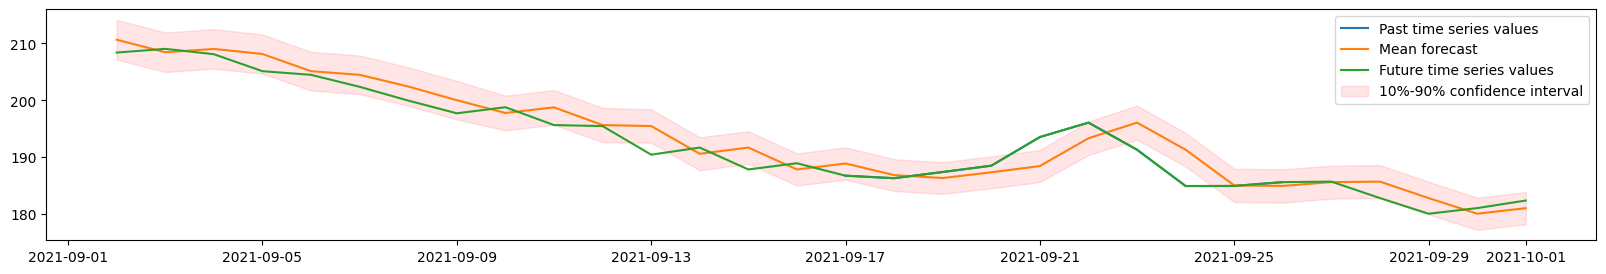

In [201]:
plt.figure(figsize=(20, 3))

item_id = 0
y_past = train_data.loc[item_id]["Close"]
y_pred = pred
y_test = test_data.loc[item_id]["Close"]

plt.plot(y_past[-10:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.2"], y_pred["0.8"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();

## Model - 1 tydzień w przód

### Trening

In [ ]:
predictor_week = TimeSeriesPredictor(
    prediction_length=5,
    path="autogluon-ms5",
    target="close",
    eval_metric="MSE"
)

predictor_week.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

### Walidacja

In [ ]:
#get only last day of prediction, but predicting it 5 days ahead
pred = pd.DataFrame(columns=['mean', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'])
for i in range(30):
  pred = pd.concat([pred, predictor_week.predict(data[-90+i:-30+i]).loc[0][-1:]])

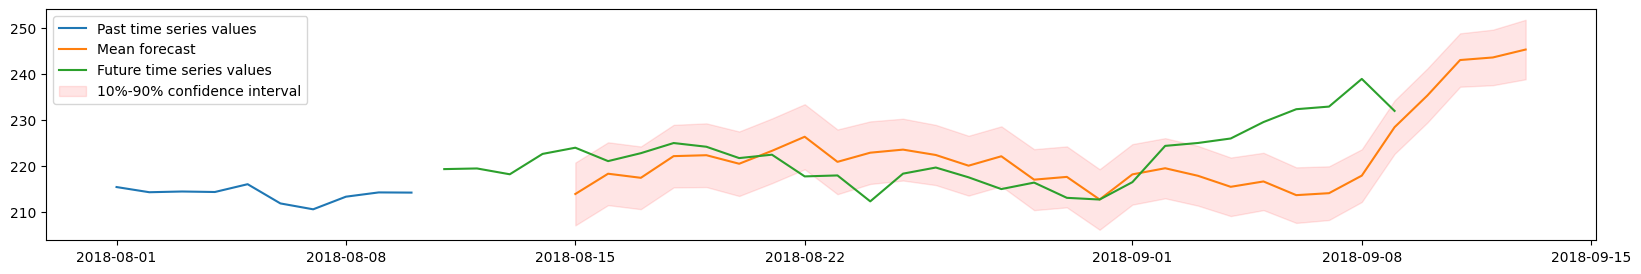

In [160]:
plt.figure(figsize=(20, 3))

item_id = 0
y_past = train_data.loc[item_id]["close"]
y_pred = pred
y_test = test_data.loc[item_id]["close"]

plt.plot(y_past[-10:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.2"], y_pred["0.8"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend()